# Estimate ENSO Influence <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** [DEA Waterbodies](https://cmi.ga.gov.au/data-products/dea/456/waterboards) time series data (available online)

## Background

The El Niño-Southern Oscillation (ENSO) is the climate driver associated with Pacific Ocean El Niño and La Niña events (ENSO phases). These events affect climate and rainfall patterns in eastern Australia. Different waterbodies are affected differently: some waterbodies, such as Kati Thanda, may only fill during La Niña; others, such as Lake Burley Griffin, are unchanged whether an ENSO phase is active or not.


### Digital Earth Australia use case 
The [DEA Waterbodies](https://cmi.ga.gov.au/data-products/dea/456/waterboards) product uses Geoscience Australia’s archive of over 30 years of Landsat satellite imagery to identify where almost 300,000 waterbodies are in the Australian landscape and tells us how the wet surface area within those waterbodies changes over time.
These data can be analysed to obtain insights into the duration and temporal dynamics of inundation for any mapped waterbody in Australia.

## Description

This notebook estimates the influence of ENSO on a DEA Waterbody using a few different metrics. This analysis should work for any time series stored in a similar format.

***

## Getting started

Run the first cell, which loads all modules needed for this notebook. Then edit the configuration to match what you want the notebook to output.

### Load modules

In [1]:
%matplotlib inline
import calendar

import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.tsa.stattools as tsa_stats
import statsmodels.tsa.seasonal as tsa_seasonal
import matplotlib.cm
import xarray
from matplotlib import pyplot as plt

import sys
sys.path.insert(1, '../../../Scripts')
import dea_waterbodies

### Configuration

To generate statistics for a waterbody with a given geohash, specify the geohash here:

In [2]:
geohash = "r4ctk0hzm"  # Kati Thanda

### Load Southern Oscillation Index

The Southern Oscillation Index (SOI) tracks ENSO based on pressure differences between Tahiti and Darwin. The United States National Oceanic and Atmospheric Administration has an easily-accessed record of the SOI, which we load here.

In [3]:
%%bash
wget https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc

--2020-11-25 05:36:16--  https://stateoftheocean.osmc.noaa.gov/atm/data/soi.nc
Resolving stateoftheocean.osmc.noaa.gov (stateoftheocean.osmc.noaa.gov)... 161.55.85.40
Connecting to stateoftheocean.osmc.noaa.gov (stateoftheocean.osmc.noaa.gov)|161.55.85.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28636 (28K) [application/x-netcdf]
Saving to: ‘soi.nc.2’

     0K .......... .......... .......                         100%  175K=0.2s

2020-11-25 05:36:17 (175 KB/s) - ‘soi.nc.2’ saved [28636/28636]



In [4]:
soi = (
    xarray.open_dataset("soi.nc").SOI * 10
)  # multiply by 10 to match standard convention.
soi = pd.DataFrame({"SOI": soi.to_pandas()}).resample("1D").mean().interpolate()
soi.index = soi.index.tz_localize('UTC')

### Load DEA Waterbodies data

We can load DEA Waterbodies time series using the `dea_waterbodies` module. Each waterbody can be looked up by its geohash.

In [5]:
time_series = dea_waterbodies.get_time_series(geohash)

# Convert percentages into a float between 0 and 1.
time_series.pc_wet /= 100

### Interpolate data to daily values

DEA Waterbodies data is stored with one row per satellite observation. 
To make our data easier to analyse by time, we can interpolate the data to estimate the percentage coverage of water for every individual day in our time series.

In [6]:
time_series = time_series.resample("1D").mean().interpolate(method='time')

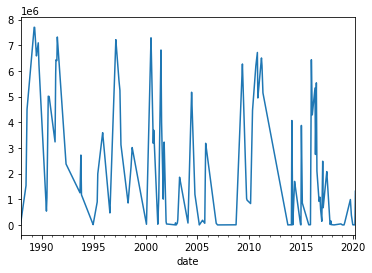

In [7]:
time_series.px_wet.plot()

## Deseasonalise the data

ENSO is weakly correlated with seasonal effects. Visualise this seasonality as in [Detecting_seasonality.ipynb](../../../Frequently_used_code/Detecting_seasonality.ipynb):

Text(0, 0.5, 'Percentage wet')

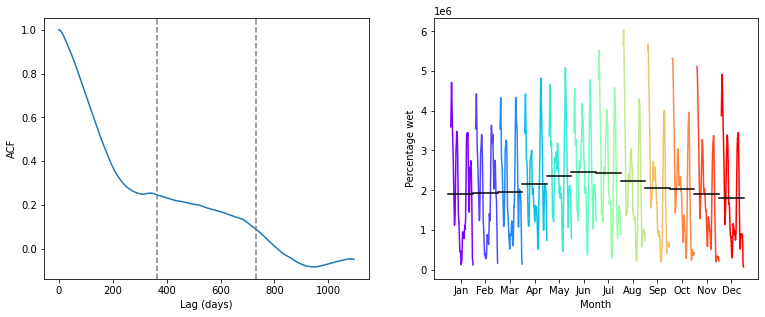

In [8]:
# ACF plot
acf = tsa_stats.acf(time_series.px_wet, nlags=365 * 3, fft=True)
plt.figure(figsize=(2 * 6.4, 4.8))
ax = plt.subplot(1, 2, 1)
ax.plot(acf)
ax.axvline(365, c='grey', linestyle='--')
ax.axvline(365 * 2, c='grey', linestyle='--')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('ACF');

# Seasonal subseries plot
titles = ["seasonal", "deseasonalised"]
colours = matplotlib.cm.rainbow(np.linspace(0, 1, 12))
ax = plt.subplot(1, 2, 2)
for month, t in time_series.px_wet.groupby(time_series.index.month):
    plt.plot(
        month + np.linspace(0, 1, len(t)),
        t.rolling(100).mean(),
        c=colours[month - 1],
    )
    plt.plot([month, month + 1], [t.mean()] * 2, c="k")
plt.xlabel("Month")
plt.xticks(np.arange(1.5, 13.5), calendar.month_abbr[1:])
plt.ylabel("Percentage wet")

There is only very weak seasonality in the autocorrelation function, but the seasonal subseries does show some clear seasonality: the waterbody is more likely to be full in early winter than the rest of the year. Deseasonalise using a seasonal decomposition from `statsmodels`:

In [9]:
seasonal_decomposition = tsa_seasonal.seasonal_decompose(time_series.px_wet, period=365, extrapolate_trend='freq')

In [10]:
deseasonalised = (seasonal_decomposition.trend + seasonal_decomposition.resid)

Text(0, 0.5, 'Percentage wet')

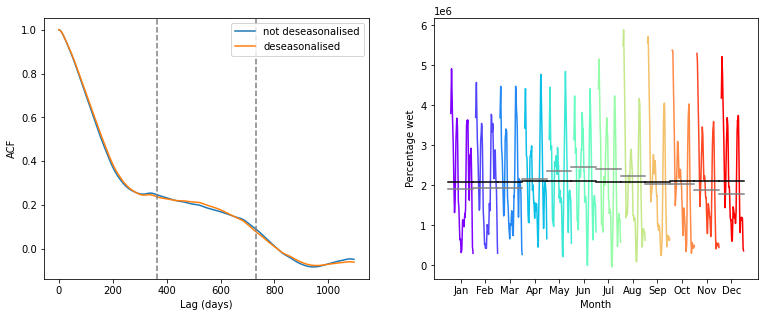

In [11]:
# ACF plot
acf_ds = tsa_stats.acf(deseasonalised, nlags=365 * 3, fft=True)
plt.figure(figsize=(2 * 6.4, 4.8))
ax = plt.subplot(1, 2, 1)
ax.plot(acf, label="not deseasonalised")
ax.plot(acf_ds, label="deseasonalised")
ax.axvline(365, c="grey", linestyle="--")
ax.axvline(365 * 2, c="grey", linestyle="--")
ax.set_xlabel("Lag (days)")
ax.set_ylabel("ACF")
ax.legend()

# Seasonal subseries plot
titles = ["seasonal", "deseasonalised"]
colours = matplotlib.cm.rainbow(np.linspace(0, 1, 12))
ax = plt.subplot(1, 2, 2)
for month, t in deseasonalised.groupby(deseasonalised.index.month):
    plt.plot(
        month + np.linspace(0, 1, len(t)),
        t.rolling(100).mean(),
        c=colours[month - 1],
    )
    plt.plot([month, month + 1], [t.mean()] * 2, c="k")
for month, t in time_series.px_wet.groupby(time_series.index.month):
    plt.plot([month, month + 1], [t.mean()] * 2, c="grey")
plt.xlabel("Month")
plt.xticks(np.arange(1.5, 13.5), calendar.month_abbr[1:])
plt.ylabel("Percentage wet")

The deseasonalised data have much less seasonal variation in the seasonal subseries plot. Apply this transformation to the time series:

In [12]:
time_series.px_wet = deseasonalised

## Estimate ENSO phases

We first need to estimate when El Niño and La Niña were active. This is indicated by the SOI being below -8 or above +8 for a sustained period, for each driver respectively (see the [Bureau of Meteorology information page on the SOI](http://www.bom.gov.au/climate/enso/history/ln-2010-12/SOI-what.shtml) for more details). We will take a four-month rolling mean and find periods where this mean was greater than or less than +8 or -8.

In [13]:
rolling_soi = soi.reindex(time_series.index).interpolate().rolling(28 * 4).mean().SOI

In [14]:
la_nina = rolling_soi > 8
el_nino = rolling_soi < -8

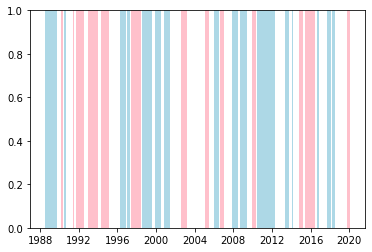

In [15]:
# Plot the El Niño and La Niña periods.
for i, group in la_nina.groupby(np.cumsum(la_nina != la_nina.shift())):
    if not group.iloc[0]:
        continue

    start = group.index[0]
    end = group.index[-1]
    plt.axvspan(start, end, facecolor="lightblue")

for i, group in el_nino.groupby(np.cumsum(el_nino != el_nino.shift())):
    if not group.iloc[0]:
        continue

    start = group.index[0]
    end = group.index[-1]
    plt.axvspan(start, end, facecolor="pink")

## Cumulative distributions of wet surface area for each phase

For El Niño, La Niña, and the neutral phase (when neither El Niño nor La Niña are active), collect all surface area observations that occurred during that phase. We can then treat these surface area observations as samples of a random variable, conditioned on the ENSO phase.

In [16]:
en_wet = time_series[el_nino].px_wet
ln_wet = time_series[la_nina].px_wet
neutral_wet = time_series[~el_nino & ~la_nina].px_wet

We can then estimate and plot the cumulative distribution functions (CDF) of the wet surface area.

In [17]:
pcs = np.linspace(0, 100, 100)
en_cdf = np.interp(pcs, np.linspace(0, 100, len(en_wet)), np.sort(en_wet))
ln_cdf = np.interp(pcs, np.linspace(0, 100, len(ln_wet)), np.sort(ln_wet))
neutral_cdf = np.interp(
    pcs, np.linspace(0, 100, len(neutral_wet)), np.sort(neutral_wet)
)

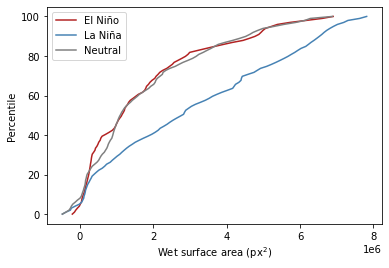

In [18]:
plt.plot(en_cdf, pcs, label="El Niño", c="firebrick")
plt.plot(ln_cdf, pcs, label="La Niña", c="steelblue")
plt.plot(neutral_cdf, pcs, label="Neutral", c="grey")
plt.ylabel("Percentile")
plt.xlabel("Wet surface area (px$^2$)")
plt.legend();

The steeper the CDF at a given surface area, the more of the time the waterbody spends at that surface area. For El Niño and neutral, the CDF starts very steep and flattens, indicating that the lake is mostly dry. The curve is much shallower for La Niña, indicating that there is a wider range of surface areas occupied by the lake. We can therefore conclude that Kati Thanda is considerably wetter during La Niña than during El Niño or neutral. We can also see that Kati Thanda during El Niño is nearly the same as during the neutral phase of ENSO, as the CDFs are almost exactly the same.

CDFs are often hard to interpret, so it is also worth looking at the probability density function (PDF), which describes the probability density of observing the waterbody at a given wet surface area during each phase. We can make the (invalid, but useful) assumption that the PDF is well-described by a Gaussian kernel, and then perform a kernel density estimate.

In [19]:
xs = np.linspace(time_series.px_wet.min(), time_series.px_wet.max(), 100)
en_pdf = scipy.stats.gaussian_kde(en_wet)
ln_pdf = scipy.stats.gaussian_kde(ln_wet)
neutral_pdf = scipy.stats.gaussian_kde(neutral_wet)

en_pdf = en_pdf(xs) / en_pdf(xs).sum()
ln_pdf = ln_pdf(xs) / ln_pdf(xs).sum()
neutral_pdf = neutral_pdf(xs) / neutral_pdf(xs).sum()

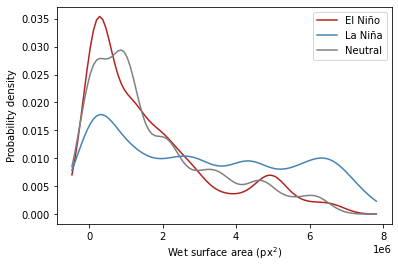

In [20]:
plt.plot(xs, en_pdf, label="El Niño", c="firebrick")
plt.plot(xs, ln_pdf, label="La Niña", c="steelblue")
plt.plot(xs, neutral_pdf, label="Neutral", c="grey")
plt.ylabel("Probability density")
plt.xlabel("Wet surface area (px$^2$)")
plt.legend();

PDFs can be clearer than CDFs. The higher the probability density at a given surface area, the more often the waterbody is at that surface area. Mathematically, the probability that the waterbody has a surface area between $x_1$ and $x_2$ is the total area under the PDF curve between these values:

$$
    p(x_1 \leq \mathrm{surface\ area} \leq x_2) = \int_{x_1}^{x_2} \mathrm{PDF}(x)\ \mathrm{d}x.
$$

The La Niña PDF is much higher than the El Niño or neutral PDFs for large surface areas, showing that Kati Thanda is wetter during La Niña. The PDF for La Niña is fairly flat, meaning that there is a roughly even chance of Kati Thanda being observed at any given surface area during La Niña.

## Difference between El Niño and La Niña compared to neutral

We can characterise the influence of ENSO over our waterbody by a) assuming that there is no confounding correlation between ENSO and water surface area, and then b) calculating the distance between the above probability distributions. There are many, many ways of comparing probability distributions. We will employ three:

1. The Kolmogorov-Smirnov (KS) distance, commonly used to determine whether two distributions are different in a test known as the "KS test". Arguably the most common statistical test, besides the Student t-test. While it is parameter-free and works on any distribution, it's also fairly weak and hence tends to under-predict differences in distributions, i.e. if it suggests that two distributions are different they probably are, but if it suggests that they are the same it might not be.
2. The sum-of-squares difference, or the Euclidean distance. This is a measure of how far apart the quantiles are, and is a good choice if you expect your quantiles to have normally-distributed noise.
3. The Kullback-Leibler (KL) divergence. This is an asymmetric measure of "surprise": given an expected distribution, how surprising is it to observe another distribution? This is a measure of relative information entropy. We will measure the KL divergence from neutral to El Niño/La Niña, which can be interpreted as the amount of information lost by approximating El Niño and La Niña as neutral. No information would be lost if they are the same distribution.

In [21]:
# Kolmogorov-Smirnov.
en_ks = abs(en_cdf - neutral_cdf).max()
ln_ks = abs(ln_cdf - neutral_cdf).max()

# Euclidean.
en_euc = np.sqrt(np.mean((en_cdf - neutral_cdf) ** 2))
ln_euc = np.sqrt(np.mean((ln_cdf - neutral_cdf) ** 2))

# Kullback-Leibler.
en_kl = np.sum(en_pdf * np.log(en_pdf / neutral_pdf))
ln_kl = np.sum(ln_pdf * np.log(ln_pdf / neutral_pdf))

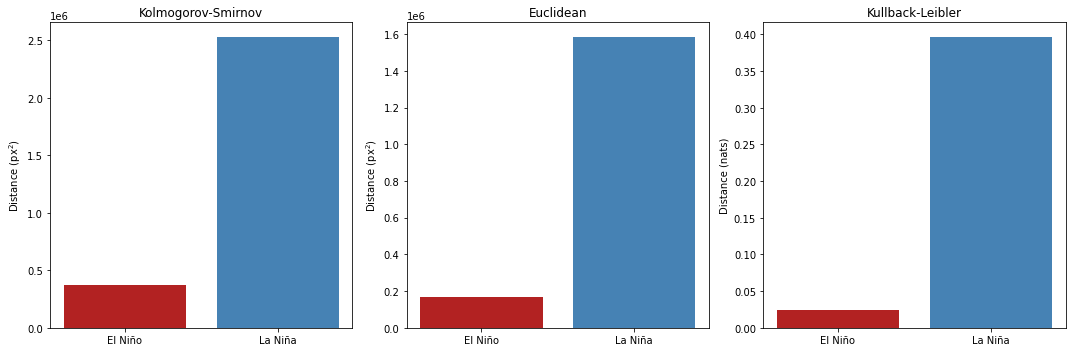

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar([0, 1], [en_ks, ln_ks], color=["firebrick", "steelblue"])
axs[0].set_title("Kolmogorov-Smirnov")
axs[0].set_ylabel("Distance (px$^2$)")
axs[1].bar([0, 1], [en_euc, ln_euc], color=["firebrick", "steelblue"])
axs[1].set_title("Euclidean")
axs[1].set_ylabel("Distance (px$^2$)")
axs[2].bar([0, 1], [en_kl, ln_kl], color=["firebrick", "steelblue"])
axs[2].set_title("Kullback-Leibler")
axs[2].set_ylabel("Distance (nats)")

for ax in axs:
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["El Niño", "La Niña"])

plt.tight_layout()

All three metrics show that Kati Thanda is heavily affected by La Niña, but not very affected by El Niño.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2020

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html).